In [3]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import argparse 
import sys
import os

sys.path.insert(0, "Epidemiology_behavior_dynamics/run")
import config as cf


In [5]:
main_path = os.path.split(os.getcwd())[0] + '/games/Epidemiology_behavior_dynamics'
config_path = main_path + '/config.csv'

config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)
config_data


config_data = pd.read_csv(config_path, sep=',', header=None, index_col=0)

networks_path = config_data.loc['networks_dir'][1]
results_path  = config_data.loc['results_dir'][1]
figures_path  = config_data.loc['figures_dir'][1]
awareness_path = config_data.loc['sigma_search_dir'][1]
infection_prob_path = config_data.loc['beta_search_dir'][1]
num_nodes     = 1000

sigma_search = pd.read_csv(os.path.join(main_path, awareness_path), dtype={'key':str, 'value':float})
beta_search  = pd.read_csv(os.path.join(main_path, infection_prob_path), dtype={'key':str, 'value':float})

time2Recover = (1/7)  # gamma

df = pd.concat([sigma_search, beta_search], axis=1)

list_df = []


for beta_fun in ["convex", "exponential", "linear", "concave", "s-shape"]:
    for type_sim in ["global", "local"]:
        #beta_fun = "linear"
        #type_sim = "global"

        df_param_run = pd.DataFrame(columns=['beta_key', 'sigma_key', 'beta_val', 'sigma_val', 'R0'])

        beta_key  = []
        sigma_key = []
        beta_val  = []
        sigma_val = []
        R0_val    = []
        for idx_sigma , r_sigma in sigma_search.iterrows():
            for idx_beta , r_beta in beta_search.iterrows():

                beta_key.append( r_beta['key']   )
                sigma_key.append( r_sigma['key'] )
                beta_val.append( r_beta['value'] )
                sigma_val.append( r_sigma['value'] )
                R0_val.append( r_beta['value'] / time2Recover )  # R0 = beta/gamma

        df_param_run['beta_key'] = beta_key  
        df_param_run['sigma_key'] = sigma_key 
        df_param_run['beta_val'] = beta_val  
        df_param_run['sigma_val'] = sigma_val 
        df_param_run['R0'] = R0_val

        for idx, r in tqdm(df_param_run.iterrows(), total=df_param_run.shape[0]):

            path_to_results = os.path.join(main_path, results_path, 
                                        beta_fun, 
                                        str(num_nodes), 
                                            type_sim, 
                                        "scale_free", 
                                        'dynamics_beta_{}_sigma_{}'.format(r['beta_key'], r['sigma_key']) +'.csv')
            res = pd.read_csv(path_to_results, usecols=['sim_id', 'time', 'S', 'I', 'C','D'])

            # Calculate mean over iterations.
            res = res.groupby('time').mean()/num_nodes
            res = res.reset_index()[['time', 'S', 'I', 'C','D']]
            res['beta']  = r['beta_val']
            res['sigma'] = r['sigma_val']
            res['R0']    = r['R0']

            res['beta_key']  = r['beta_key']
            res['sigma_key'] = r['sigma_key']
            res["type"]      = type_sim
            res["function"]  = beta_fun

            list_df.append(res)

df_response = pd.concat(list_df)



100%|██████████| 121/121 [00:01<00:00, 87.77it/s]


In [6]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

betas = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
sigma = [0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]
R_0   = [0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]
R_0

[0.0, 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7.0]

In [7]:
df_response_s = df_response[df_response.sigma>0.4].copy()
df_response_s = df_response_s.replace({"linear": "Linear", "convex": "Convex", "concave": "Concave 1", "exponential": "Exponential", "s-shape": "Concave 2"})

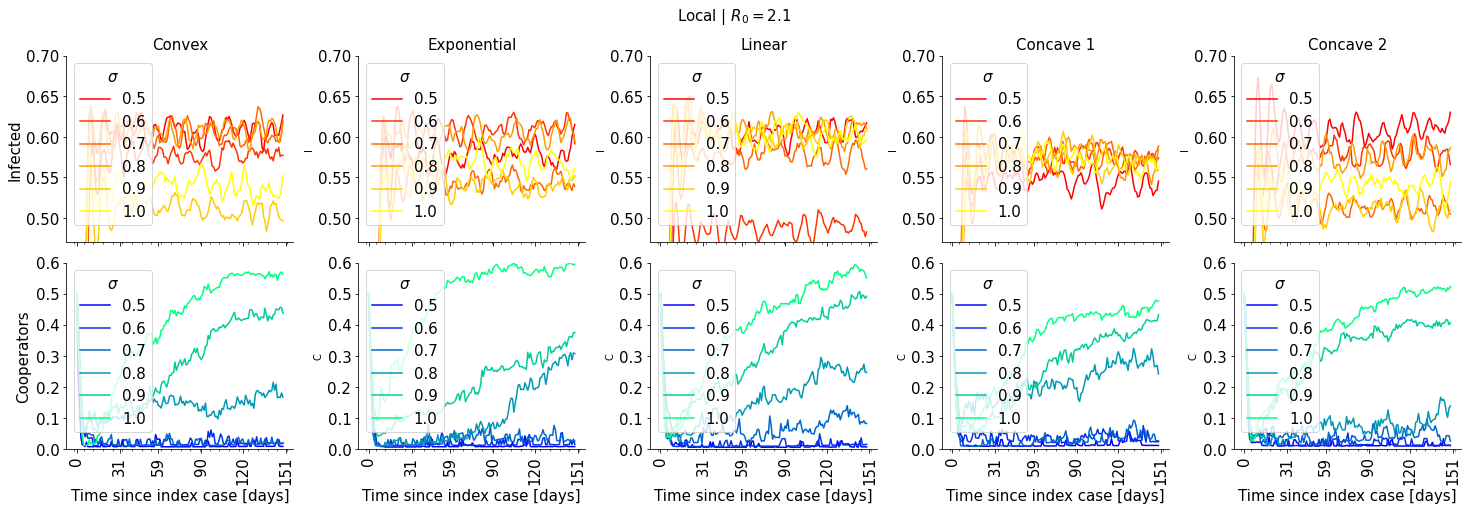

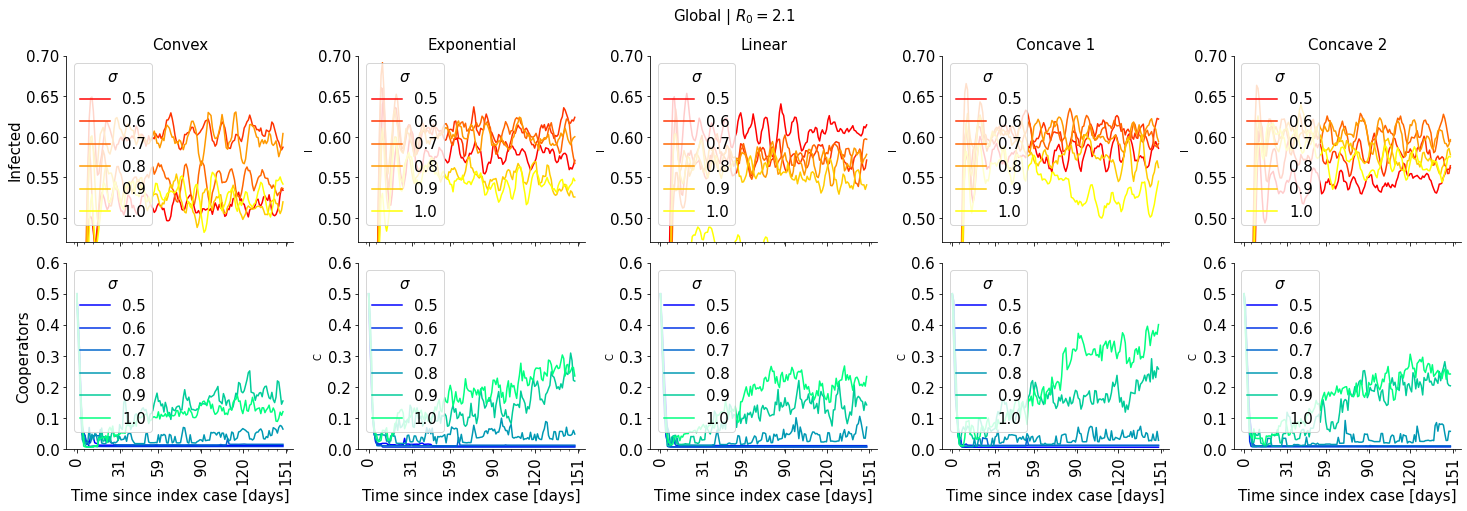

In [22]:
import seaborn as sns

ssss = ["Convex", "Exponential", "Linear", "Concave 1", "Concave 2"]
colors_plt = [ 'tab:red', 'royalblue', 'green', 'tab:purple', 'tab:cyan', 'tab:orange' ]

type_s = "global"
for type_s in ["local", "global"]:
    fig, ax = plt.subplots(2, 5, figsize=(20.5, 7.2), sharex=True, sharey=False)
    for idx_t, ttype in enumerate(ssss):
        df_response_plt = df_response_s[df_response_s.beta==0.3].copy()
        df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        df_response_plt = df_response_plt.reset_index()

        sns.lineplot(ax = ax[0,idx_t], data=df_response_plt, x="time", y="I", hue="sigma", palette='autumn')
        sns.lineplot(ax = ax[1,idx_t], data=df_response_plt, x="time", y="C", hue="sigma", palette="winter")

        ax[0,idx_t].set_title(f"{ttype.capitalize()}", fontsize=15)

        ax[1,idx_t].set_ylim([0, 0.6])

        ax[0,idx_t].set_ylim([0.47, 0.7])
    ax[0,0].set_ylabel(f"Infected", fontsize=15)
    ax[1,0].set_ylabel(f"Cooperators", fontsize=15)

    for idx, axi in enumerate(ax.flatten()):
        axi.xaxis.set_major_locator(mdates.MonthLocator())
        axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
        axi.tick_params( which='both', axis='both', labelsize=15)
        axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.set_xlabel("Time since index case [days]", fontsize=15)
        axi.legend(fontsize=15, loc='upper left', title=r"$\sigma$", title_fontsize=15)

    fig.suptitle(f"{type_s.capitalize()} |"+ r" $R_0=2.1$", fontsize=15) 
    plt.tight_layout()


    fig.savefig(f"{type_s}_r0_low.png",  dpi=300, transparent = False, bbox_inches = 'tight')


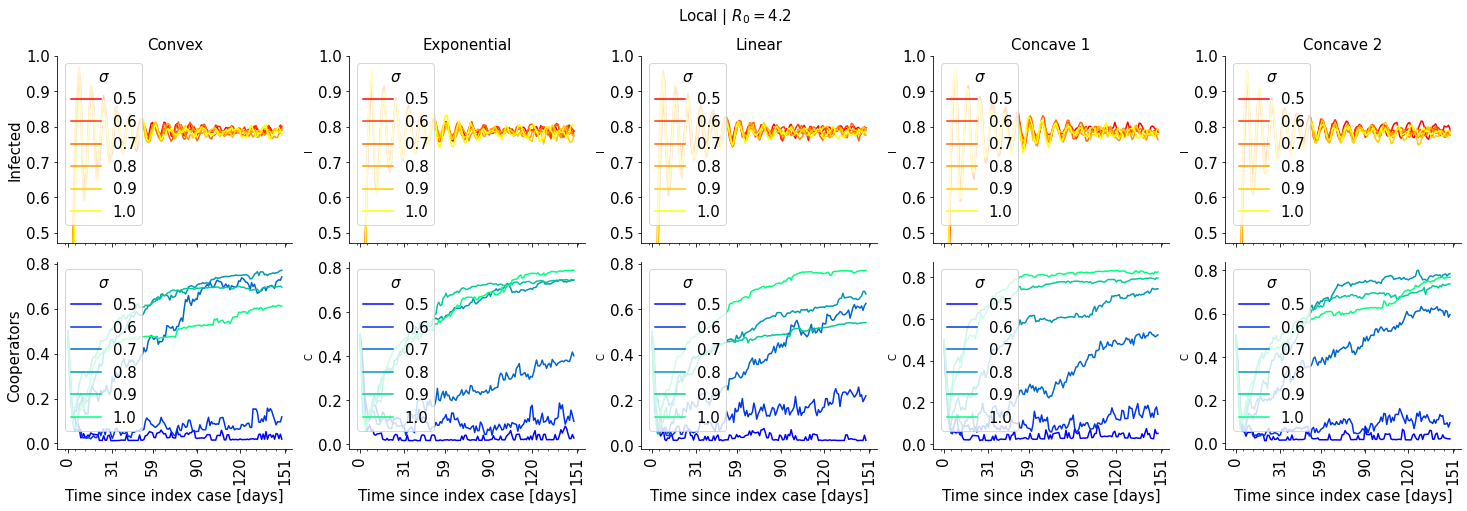

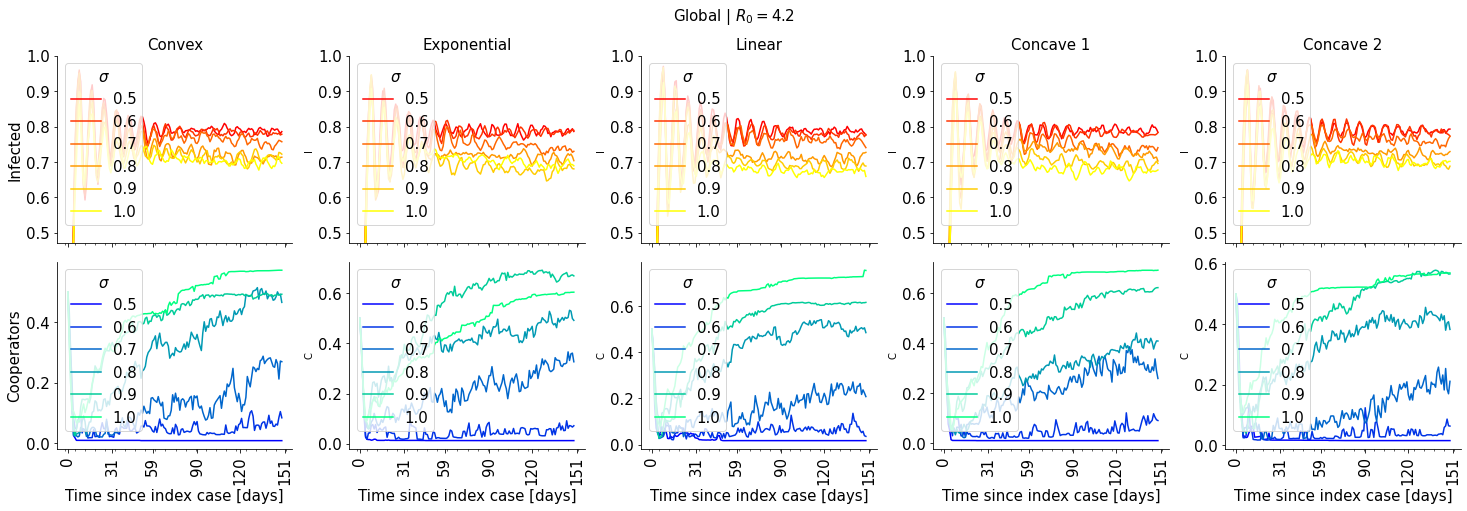

In [21]:


import seaborn as sns

ssss = ["Convex", "Exponential", "Linear", "Concave 1", "Concave 2"]


type_s = "global"
for type_s in ["local", "global"]:
    fig, ax = plt.subplots(2, 5, figsize=(20.5, 7.2), sharex=True, sharey=False)
    for idx_t, ttype in enumerate(ssss):
        df_response_plt = df_response_s[df_response_s.beta==0.6].copy()
        df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        df_response_plt = df_response_plt.reset_index()

        sns.lineplot(ax = ax[0,idx_t], data=df_response_plt, x="time", y="I", hue="sigma", palette='autumn')
        sns.lineplot(ax = ax[1,idx_t], data=df_response_plt, x="time", y="C", hue="sigma", palette="winter")

        ax[0,idx_t].set_title(f"{ttype.capitalize()}", fontsize=15)

        #ax[1,idx_t].set_ylim([0, 0.5])

        ax[0,idx_t].set_ylim([0.47, 1])
    ax[0,0].set_ylabel(f"Infected", fontsize=15)
    ax[1,0].set_ylabel(f"Cooperators", fontsize=15)
    for idx, axi in enumerate(ax.flatten()):
        axi.xaxis.set_major_locator(mdates.MonthLocator())
        axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
        axi.tick_params( which='both', axis='both', labelsize=15)
        axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.set_xlabel("Time since index case [days]", fontsize=15)
        axi.legend(fontsize=15, loc='upper left', title=r"$\sigma$", title_fontsize=15)

    fig.suptitle(f"{type_s.capitalize()} |"+ r" $R_0=4.2$", fontsize=15) 
    plt.tight_layout()
    fig.savefig(f"{type_s}_r0_medium.png",  dpi=300, transparent = False, bbox_inches = 'tight')



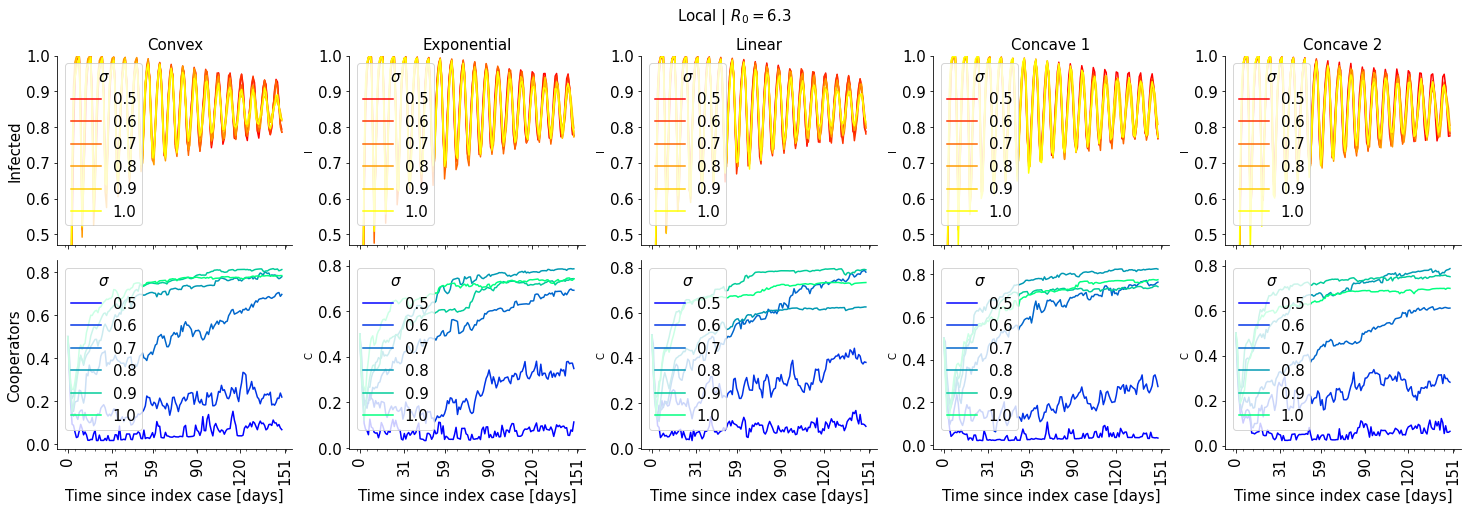

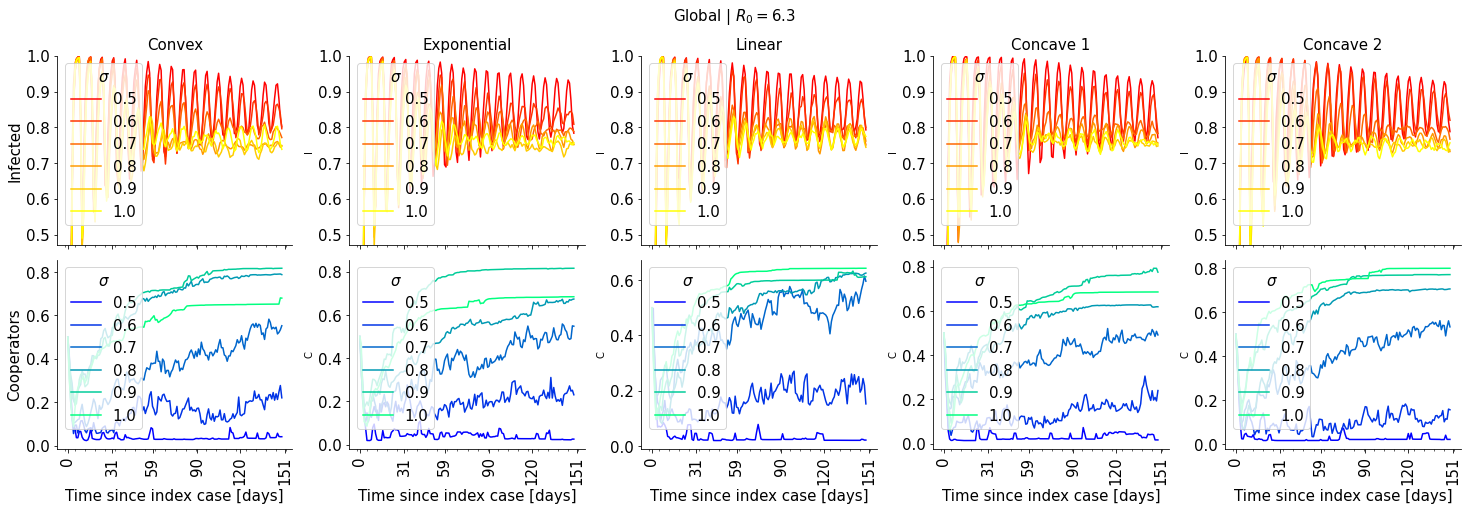

In [23]:


import seaborn as sns

ssss = ["Convex", "Exponential", "Linear", "Concave 1", "Concave 2"]

type_s = "global"
for type_s in ["local", "global"]:
    fig, ax = plt.subplots(2, 5, figsize=(20.5, 7.2), sharex=True, sharey=False)
    for idx_t, ttype in enumerate(ssss):
        df_response_plt = df_response_s[df_response_s.beta==0.9].copy()
        df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        df_response_plt = df_response_plt.reset_index()

        sns.lineplot(ax = ax[0,idx_t], data=df_response_plt, x="time", y="I", hue="sigma", palette='autumn')
        sns.lineplot(ax = ax[1,idx_t], data=df_response_plt, x="time", y="C", hue="sigma", palette="winter")

        ax[0,idx_t].set_title(f"{ttype.capitalize()}", fontsize=15)

        #ax[1,idx_t].set_ylim([0, 0.5])
        ax[0,idx_t].set_ylim([0.47, 1])

    ax[0,0].set_ylabel(f"Infected", fontsize=15)
    ax[1,0].set_ylabel(f"Cooperators", fontsize=15)
    for idx, axi in enumerate(ax.flatten()):
        axi.xaxis.set_major_locator(mdates.MonthLocator())
        axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
        axi.tick_params( which='both', axis='both', labelsize=15)
        axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
        axi.spines['right'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.set_xlabel("Time since index case [days]", fontsize=15)
        axi.legend(fontsize=15, loc='upper left', title=r"$\sigma$", title_fontsize=15)

    fig.suptitle(f"{type_s.capitalize()} |"+ r" $R_0=6.3$", fontsize=15) 
    plt.tight_layout()
    fig.savefig(f"{type_s}_r0_high.png",  dpi=300, transparent = False, bbox_inches = 'tight')




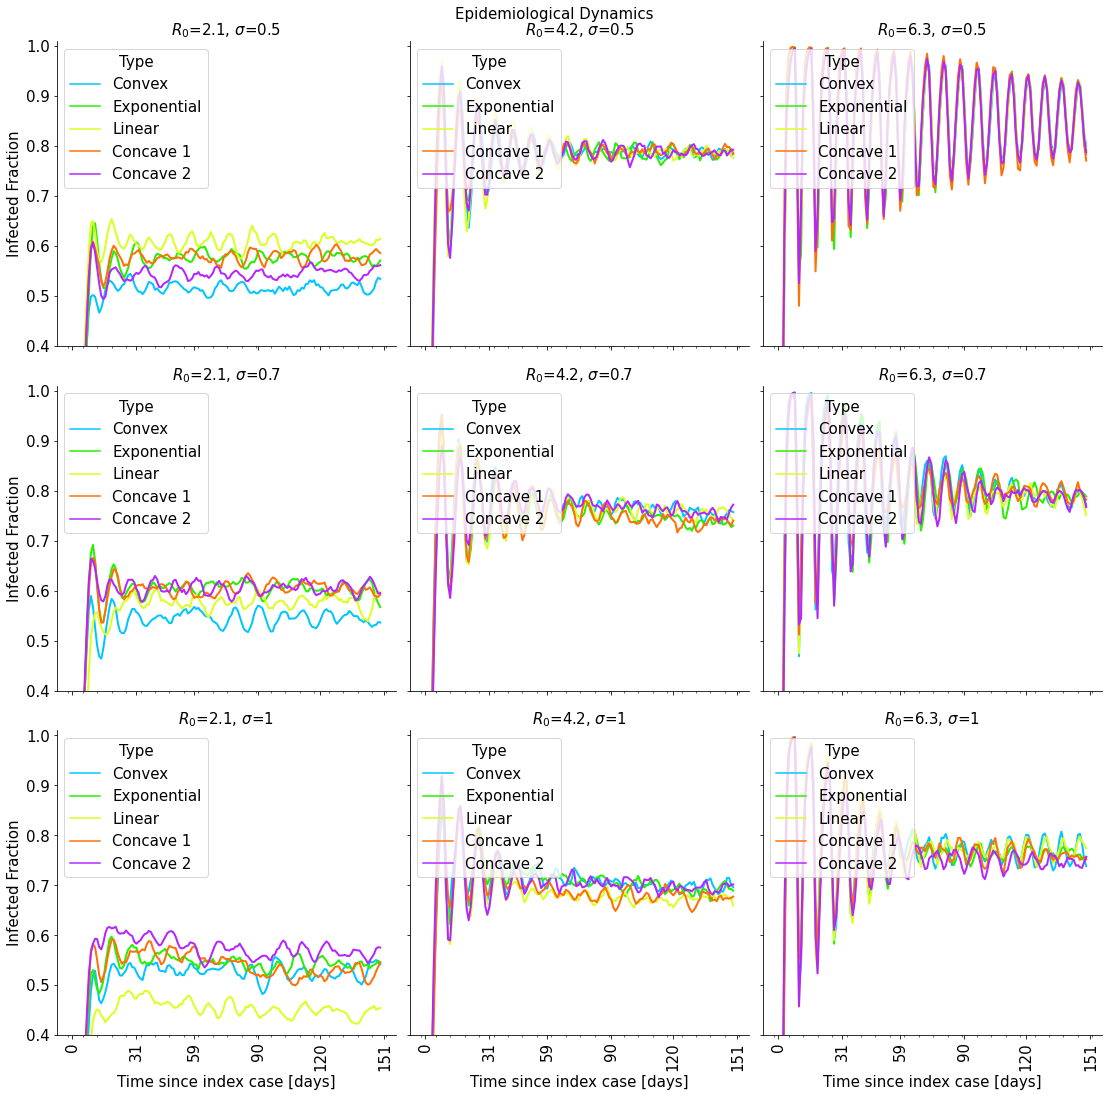

In [15]:
beta_f2    = [0.3, 0.6, 0.9]
ro_f2      = [2.1, 4.2, 6.3]

awareness_f2 = [0.5, 0.7, 1]
kind_l       = ["Low", "Medium", "Full"]


fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)
type_s = "global"

import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_response_s[df_response_s.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="I", hue="function", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0.4, 1.01])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Infected Fraction", fontsize=15)
    axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="upper left")

fig.suptitle(f"Epidemiological Dynamics", fontsize=15) 
plt.tight_layout()
fig.savefig("infected_grid_r0sigma.png",  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)


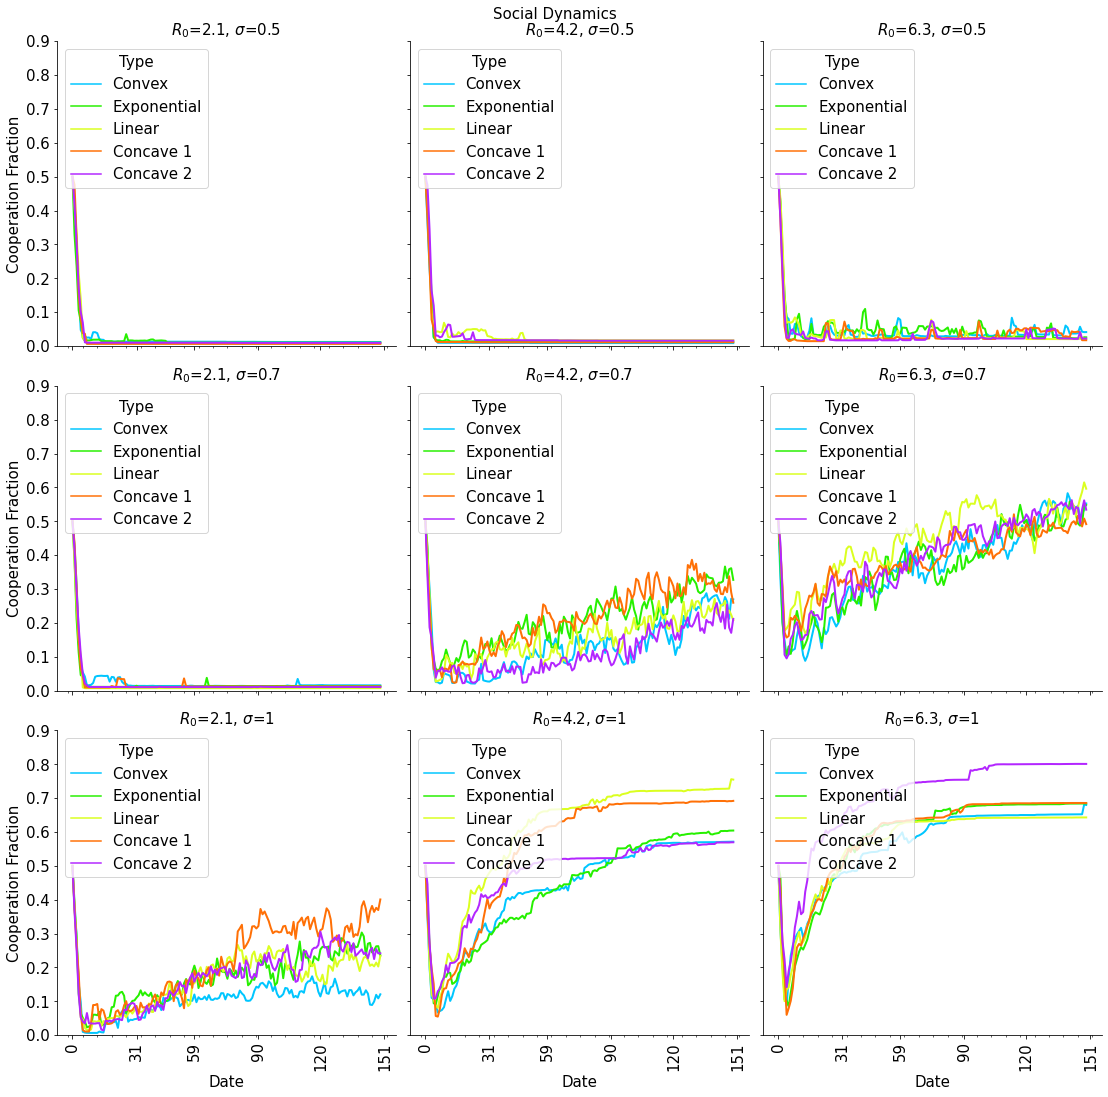

In [14]:
beta_f2      = [0.3, 0.6, 0.9]
ro_f2      = [2.1, 4.2, 6.3]

awareness_f2 = [0.5, 0.7, 1]
kind_l       = ["Low", "Medium", "Full"]


fig, ax = plt.subplots(3, 3, figsize=(15.5, 15.5), sharex=True, sharey=True)
type_s = "global"

import pylab 

cm = pylab.get_cmap('gist_ncar') 
for idx_b, beta in enumerate(beta_f2):
    for idx_s, sigma in enumerate(awareness_f2):

        df_response_plt = df_response_s[df_response_s.beta==beta].copy()
        df_response_plt = df_response_plt[df_response_plt.sigma==sigma].copy()
        #df_response_plt = df_response_plt[df_response_plt.function==ttype]
        df_response_plt = df_response_plt[df_response_plt.type==type_s]

        sns.lineplot(ax=ax[idx_s, idx_b], data=df_response_plt.reset_index(), x="time", y="C", hue="function", palette="gist_ncar", lw=2)
        ax[idx_s, idx_b].set_ylim([0, 0.9])
        ax[idx_s, idx_b].set_title(r"$R_0$={}, $\sigma$={}".format(ro_f2[idx_b], sigma), fontsize=15)

for axi in ax.flatten():
    axi.xaxis.set_major_locator(mdates.MonthLocator())
    axi.xaxis.set_minor_locator(mdates.WeekdayLocator())
    axi.tick_params( which='both', axis='both', labelsize=15)
    axi.tick_params( which='both', axis='x', labelrotation=90, labelsize=15)
    axi.spines['right'].set_visible(False)
    axi.spines['top'].set_visible(False)
    axi.set_xlabel("Time since index case [days]", fontsize=15)
    axi.set_ylabel("Cooperation Fraction", fontsize=15)
    #axi.legend(fontsize=15, title=None, loc="upper left")
    axi.legend(fontsize=15, title="Type", title_fontsize=15, loc="upper left")

fig.suptitle(f"Social Dynamics", fontsize=15) 

plt.tight_layout()
fig.savefig("cooperation_grid_r0sigma.png",  dpi=300, transparent = False, bbox_inches = 'tight', pad_inches = 0.1)